In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# if 'train.tsv' not in os.listdir(): 
#     !kaggle competitions download -c mercari-price-suggestion-challenge
#     get_ipython().system_raw("7z x \*.7z && rm *.7z")
#     get_ipython().system_raw("7z x \*.zip && rm *.zip")

# Unzip data files
!apt install --assume-yes p7zip-full
!7z x ../input/mercari-price-suggestion-challenge/train.tsv.7z -y
!7z x ../input/mercari-price-suggestion-challenge/test.tsv.7z -y
!7z x ../input/mercari-price-suggestion-challenge/test_stg2.tsv.zip -y
!7z x ../input/mercari-price-suggestion-challenge/sample_submission.csv.7z -y
# !7z x ../input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip -y




The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 1522 kB of archives.
After this operation, 5755 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip-full amd64 16.02+dfsg-6 [1164 kB]
Fetched 1522 kB in 1s (1062 kB/s)
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package p7zip.
(Reading database ... 95327 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  9%] [#####.....................................................] 8Unpacking p7zip (16.02+d

In [3]:
train_path = './train.tsv'
test_path = './test.tsv'

In [4]:
import pandas as pd

train_df = pd.read_csv(train_path, sep='\t')
test_df = pd.read_csv(test_path, sep = '\t')

# train_df = train_df.head(8000)
# test_df = test_df.head(6000)

train_df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
test_df.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


### Price Processing

In [6]:
def remove_invalid_price(df):
    if 'price' in df:
#         df = df[df.price >= 5]  # Removing the prodicts with prices less than 5
#         df = df[df.price <= 2000]  # Removing the prodicts with prices more than 2000
#     return df
        df.drop(df[df['price'] < 5].index, inplace = True)
        df.drop(df[df['price'] > 2000].index, inplace = True)

In [7]:
# remove_invalid_price(train_df)
# train_df[(train_df.price < 5) & (train_df.price > 2000)]

In [8]:
def create_log_price(df):
    if 'price' in df:
        df['log_prices']= np.log(df['price'].values)

In [9]:
# create_log_price(train_df)
# train_df.head(5)

### Handling null values


In [10]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

### Splitting categories

In [11]:
# tách caterory ra làm 3 category con
def split_categories(category):
    try:
        sub_cat_1,sub_cat_2,sub_cat_3 = category.split("/")
        return sub_cat_1,sub_cat_2,sub_cat_3
    except:
        return ("None","None","None")

# sử dụng hàm split_categories để tách category ra làm 3 category con và tạo thành 3 cột mới : 'main_category', 'sub_cat_1','sub_cat_2'
def create_split_categories(data):
    if 'category_name' in data:
        data['general_cat'],data['subcat_1'],data['subcat_2']= zip(*data['category_name'].\
                                                                    apply(lambda x: split_categories(x)))
#         data.drop('category_name',axis='columns', inplace=True)

In [12]:
# fill_missing_values(train_df)
# create_split_categories(train_df)

### Text Processing

In [13]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess_descriptive_text_column(text_data):
    """
    Description:
    This function will process the text data.

    Input: original strings [in list form]
    Output: processed strings [in list form]
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    processed_text = []
    for sentance in tqdm(text_data):
        sent = decontract_text(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        processed_text.append(sent.lower().strip())
    return np.array(processed_text)

In [14]:
def preprocess_cols(df):
    df['name'] = preprocess_descriptive_text_column(df['name'].values)
    df['brand_name'] = df['brand_name'].apply(lambda x: str(x).lower())
    df['item_description'] = preprocess_descriptive_text_column(df['item_description'].values)
    df['general_cat'] = preprocess_descriptive_text_column(df['general_cat'].values)
    df['subcat_1'] = preprocess_descriptive_text_column(df['subcat_1'].values)
    df['subcat_2'] = preprocess_descriptive_text_column(df['subcat_2'].values)

In [15]:
train_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


### Fill Missing Brand Name

In [16]:
# inspired from https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def concat_categories(x):
        return set(x.values)

def brand_guesser(df):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want out guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe with missing brand names
    Output: dataframe with filled brand names
    """
    existing_brands = df[df['brand_name'] != 'unk_brand']['brand_name'].unique()
    brand_names_categories = dict(df[df['brand_name'] != 'unk_brand'][['brand_name','category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    filled_brands = []
    for row in tqdm(df[['brand_name','name','category_name']].values):
        found=False
        if row[0]=='unk_brand':
            for brand in existing_brands:
                if brand in row[1] and row[2] in brand_names_categories[brand] :
                    filled_brands.append(brand)
                    found=True
                    break
            if not found:
                filled_brands.append('unk_brand')
        else:
            filled_brands.append(row[0])

    df['brand_name']=filled_brands
    return df

In [17]:
def fill_missing_brands(df):
    print('Unknown brand before guessing:', df['brand_name'].value_counts()['unk_brand'])
    df = brand_guesser(df)
    print('Unknown brand after guessing:', df['brand_name'].value_counts()['unk_brand'])

### Adding Sentiment score

In [18]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def get_sentiments_feature(df):
    """
    Description:
    This function will calculate the sentiment scores of each item description.
    It will calculate four scores for each sentence; compund, negetive, neutral, positive

    Input: Dataframe
    Output: sentiment scores for all the product's description
    """
    sentiments = []
    neg = []
    neu = []
    pos = []
    sid = SentimentIntensityAnalyzer()
    for desc in tqdm(df['item_description'].apply(str).values):
        ss = sid.polarity_scores(desc)
        sentiments.append([ss['neg'],ss['neu'],ss['pos']])
        neg.append(ss['neg'])
        neu.append(ss['neu'])
        pos.append(ss['pos'])
#     return np.array(sentiments)
    return neg, neu, pos

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
# sentiments_feature = get_sentiments_feature(train_df)

In [20]:
# neg, neu, pos = sentiments_feature
# neg

In [21]:
# train_df['desc_neg'] = neg
# train_df['desc_neu'] = neu
# train_df['desc_pos'] = pos
# train_df

In [22]:
def add_sentiment_scores(df):
    neg, neu, pos = get_sentiments_feature(df)
    df['desc_neg'] = neg
    df['desc_neu'] = neu
    df['desc_pos'] = pos

In [23]:
train_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### Expensive brand

In [24]:
# ##print 90 to 100 percentile values with step size of 1. 
# unique_gen_cat = train_df['general_cat'].unique()
# cat_threshold_percetile = {}
# for gc_ in unique_gen_cat: 
#     print(gc_,"\n-------------")
#     for i in range(90,101):
#         print(i,"th percentile is",np.percentile(train_df[train_df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, i))
#     cat_threshold_percetile[gc_]=np.percentile(train_df[train_df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, 95)
# #     print()

In [25]:
# expensive_brands = []
# unique_gen_cat = train_df['general_cat'].unique()
# for gc_ in unique_gen_cat:
#     temp_df = train_df[train_df['general_cat']==gc_][['brand_name','price']].values
#     for row in temp_df:
#         if row[1]>=cat_threshold_percetile[gc_]:
#             expensive_brands.append(row[0])
# expensive_brands = list(set(expensive_brands))
# try:
#     expensive_brands.remove('unk_brand')
# except:
#     pass

In [26]:
# expensive_brands

In [27]:
def add_expensive_brands(df):
    ##print 90 to 100 percentile values with step size of 1. 
    unique_gen_cat = df['general_cat'].unique()
    cat_threshold_percetile = {}
    for gc_ in unique_gen_cat: 
#         print(gc_,"\n-------------")
#         for i in range(90,101):
#             print(i,"th percentile is",np.percentile(df[df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, i))
        cat_threshold_percetile[gc_]=np.percentile(train_df[train_df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, 95)
    #     print()
    
    expensive_brands = []
    
    unique_gen_cat = train_df['general_cat'].unique()
    for gc_ in unique_gen_cat:
        temp_df = train_df[train_df['general_cat']==gc_][['brand_name','price']].values
        for row in temp_df:
            if row[1]>=cat_threshold_percetile[gc_]:
                expensive_brands.append(row[0])
    expensive_brands = list(set(expensive_brands))
    try:
        expensive_brands.remove('unk_brand')
    except:
        pass
    
    df['is_expensive'] = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)

In [28]:
train_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


### Adding len of desrciption and name

In [29]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the item name and standardize it.

    Input: Series, fitted scaler[during inference]
    Output: standardized name length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

In [30]:
# name_len, scaler_name_len =  get_len_feature(train_df['name'])
# desc_len, scaler_desc_len =  get_len_feature(train_df['item_description'])

In [31]:
def add_len_features(df):
    name_len, scaler_name_len =  get_len_feature(df['name'])
    desc_len, scaler_desc_len =  get_len_feature(df['item_description'])
    df['scaler_name_len'] = name_len
    df['scaler_desc_len'] = desc_len

In [32]:
def combine_processes(df):
    print('Removing invalid price ...')
    remove_invalid_price(df)
    print('Completed \n')
    
    print('Creating log price ...')
    create_log_price(df)
    print('Completed \n')
    
    print('Filling NaN values ...')
    fill_missing_values(df)
    print('Completed \n')
    
    print('Splitting categories ...')
    create_split_categories(df)
    print('Completed \n')
    
    print('Filling unknown brands ...')
    fill_missing_brands(df)
    print('Completed \n')
    
    print('Cleaning text columns ...')
    preprocess_cols(df)
    print('Completed \n')
    
    print('Adding sentiment scores ...')
    add_sentiment_scores(df)
    print('Completed \n')
    
    print('Adding expensive brands ...')
    add_expensive_brands(df)
    print('Completed \n')
    
    print('Adding description len and name len ...')
    add_len_features(df)
    print('Completed \n')

In [33]:
combine_processes(train_df)

Removing invalid price ...
Completed 

Creating log price ...
Completed 

Filling NaN values ...
Completed 

Splitting categories ...
Completed 

Filling unknown brands ...
Unknown brand before guessing: 607593


  0%|          | 0/1446816 [00:00<?, ?it/s]

Unknown brand after guessing: 514454
Completed 

Cleaning text columns ...


  0%|          | 0/1446816 [00:00<?, ?it/s]

  0%|          | 0/1446816 [00:00<?, ?it/s]

  0%|          | 0/1446816 [00:00<?, ?it/s]

  0%|          | 0/1446816 [00:00<?, ?it/s]

  0%|          | 0/1446816 [00:00<?, ?it/s]

Completed 

Adding sentiment scores ...


  0%|          | 0/1446816 [00:00<?, ?it/s]

Completed 

Adding expensive brands ...
Completed 

Adding description len and name len ...
Completed 



In [34]:
train_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2,desc_neg,desc_neu,desc_pos,is_expensive,scaler_name_len,scaler_desc_len
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,mlb,10.0,1,no description yet,2.302585,men,tops,shirts,0.524,0.476,0.000,1,1.125913,-0.739503
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,razer,52.0,0,keyboard great condition works like came box p...,3.951244,electronics,computers tablets,components parts,0.000,0.581,0.419,1,-0.135020,-0.019725
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,target,10.0,1,adorable top hint lace key hole back pale pink...,2.302585,women,tops blouses,blouse,0.000,0.706,0.294,1,-0.765487,-0.211666
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,unk_brand,35.0,1,new tags leather horses retail rm stand foot h...,3.555348,home,home cor,home cor accents,0.000,0.741,0.259,0,-0.765487,-0.019725
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,unk_brand,44.0,0,complete certificate authenticity,3.784190,women,jewelry,necklaces,0.000,1.000,0.000,0,-0.135020,-0.739503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,Women/Dresses/Mid-Calf,free people,20.0,1,lace says size small fits medium perfectly nev...,2.995732,women,dresses,mid calf,0.326,0.509,0.165,1,-0.135020,-0.067710
1482531,1482531,little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,disney,14.0,0,little mermaid handmade dress never worn size 2t,2.639057,kids,girls 2t 5t,dresses,0.000,0.788,0.212,1,-0.135020,-0.499577
1482532,1482532,21 day fix containers eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,unk_brand,12.0,0,used twice still great shape,2.484907,sports outdoors,exercise,fitness accessories,0.000,0.494,0.506,0,1.125913,-0.643533
1482533,1482533,world markets lanterns,3,Home/Home Décor/Home Décor Accents,unk_brand,45.0,1,2 one see 2 red 2 orange 2 big red orange ones...,3.806662,home,home cor,home cor accents,0.000,1.000,0.000,0,-0.765487,-0.211666


In [35]:
train_df[(train_df['price'] < 5) | (train_df['price'] > 2000)]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2,desc_neg,desc_neu,desc_pos,is_expensive,scaler_name_len,scaler_desc_len


<AxesSubplot:>

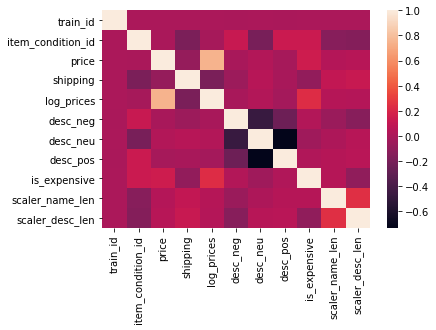

In [36]:
import seaborn as sns
corr = train_df.corr()
heatmap = sns.heatmap(corr)
heatmap

In [37]:
corr

,train_id,item_condition_id,price,shipping,log_prices,desc_neg,desc_neu,desc_pos,is_expensive,scaler_name_len,scaler_desc_len
train_id,1.000000,-0.000138,0.000276,0.000790,0.000324,-0.000581,0.000964,-0.000485,-0.000112,0.000303,0.000213
item_condition_id,-0.000138,1.000000,-0.005691,-0.187134,-0.018622,0.115485,-0.199419,0.131450,0.130198,-0.139811,-0.150790
price,0.000276,-0.005691,1.000000,-0.082899,0.743444,-0.013762,0.028619,-0.020565,0.142523,0.035541,0.053007
shipping,0.000790,-0.187134,-0.082899,1.000000,-0.193864,-0.057534,0.048949,-0.009711,-0.100738,0.095619,0.115954
log_prices,0.000324,-0.018622,0.743444,-0.193864,1.000000,-0.012364,0.030193,-0.023095,0.231635,0.046475,0.038443
desc_neg,-0.000581,0.115485,-0.013762,-0.057534,-0.012364,1.000000,-0.470958,-0.247469,0.033201,-0.067158,-0.139727
desc_neu,0.000964,-0.199419,0.028619,0.048949,0.030193,-0.470958,1.000000,-0.730357,-0.042955,0.012261,0.047680
desc_pos,-0.000485,0.131450,-0.020565,-0.009711,-0.023095,-0.247469,-0.730357,1.000000,0.023346,0.040934,0.057710
is_expensive,-0.000112,0.130198,0.142523,-0.100738,0.231635,0.033201,-0.042955,0.023346,1.000000,0.045377,-0.105403
scaler_name_len,0.000303,-0.139811,0.035541,0.095619,0.046475,-0.067158,0.012261,0.040934,0.045377,1.000000,0.243756


In [38]:
train_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
log_prices           0
general_cat          0
subcat_1             0
subcat_2             0
desc_neg             0
desc_neu             0
desc_pos             0
is_expensive         0
scaler_name_len      0
scaler_desc_len      0
dtype: int64

In [39]:
# compression_train = dict(method='zip', archive_name='train_processed.csv')  
# train_df.to_csv('train_out.zip', index=False, compression=compression_train)
# train_df.to_csv('train_processed.csv', index=False)

In [40]:
# Save to pkl file to avoid missing data
with open('./train_processed.pkl', 'wb') as f:
    pickle.dump(train_df, f)

In [41]:
combine_processes(test_df)
test_df

Removing invalid price ...
Completed 

Creating log price ...
Completed 

Filling NaN values ...
Completed 

Splitting categories ...
Completed 

Filling unknown brands ...
Unknown brand before guessing: 295525


  0%|          | 0/693359 [00:00<?, ?it/s]

Unknown brand after guessing: 255299
Completed 

Cleaning text columns ...


  0%|          | 0/693359 [00:00<?, ?it/s]

  0%|          | 0/693359 [00:00<?, ?it/s]

  0%|          | 0/693359 [00:00<?, ?it/s]

  0%|          | 0/693359 [00:00<?, ?it/s]

  0%|          | 0/693359 [00:00<?, ?it/s]

Completed 

Adding sentiment scores ...


  0%|          | 0/693359 [00:00<?, ?it/s]

Completed 

Adding expensive brands ...
Completed 

Adding description len and name len ...
Completed 



,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,desc_neg,desc_neu,desc_pos,is_expensive,scaler_name_len,scaler_desc_len
0,0,breast cancer fight like girl ring,1,Women/Jewelry/Rings,unk_brand,1,size 7,women,jewelry,rings,0.000,1.000,0.000,0,1.132324,-0.785185
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,Other/Office supplies/Shipping Supplies,unk_brand,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,,office supplies,shipping supplies,0.000,0.718,0.282,0,3.025140,0.748413
2,2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,coach,1,brand new coach bag bought rm coach outlet,vintage collectibles,bags purses,handbag,0.000,1.000,0.000,1,-1.391432,-0.497636
3,3,floral kimono,2,Women/Sweaters/Cardigan,unk_brand,0,floral kimono never worn lightweight perfect h...,women,sweaters,cardigan,0.275,0.551,0.173,0,-1.391432,-0.497636
4,4,life death,3,Other/Books/Religion & Spirituality,unk_brand,1,rediscovering life loss loved one tony cooke p...,,books,religion spirituality,0.281,0.419,0.299,0,-1.391432,0.125388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693354,693354,quartz crystal flint stone,1,Home/Home Décor/Home Décor Accents,unk_brand,0,flint quartz cluster self mined measures 3x2in...,home,home cor,home cor accents,0.104,0.812,0.085,0,-0.129554,0.365013
693355,693355,cosmetics travel bundle,1,Beauty/Makeup/Makeup Sets,it cosmetics,1,cosmetics travel bundle includes brow power un...,beauty,makeup,makeup sets,0.087,0.713,0.199,1,-0.760493,3.911458
693356,693356,galaxy s8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",unk_brand,1,new free shipping basstop case,electronics,cell phones accessories,cases covers skins,0.000,0.548,0.452,0,0.501385,-0.641410
693357,693357,hi low floral kimono,2,Women/Swimwear/Cover-Ups,unk_brand,0,floral kimono tropical print open front hi low...,women,swimwear,cover ups,0.130,0.617,0.253,0,-0.129554,-0.305936


In [42]:
# compression_test = dict(method='zip', archive_name='test_processed.csv')  
# test_df.to_csv('test_out.zip', index=False, compression=compression_test) 
with open('./test_processed.pkl', 'wb') as f:
    pickle.dump(test_df, f)

In [43]:
train_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
log_prices           0
general_cat          0
subcat_1             0
subcat_2             0
desc_neg             0
desc_neu             0
desc_pos             0
is_expensive         0
scaler_name_len      0
scaler_desc_len      0
dtype: int64

In [44]:
test_df

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,desc_neg,desc_neu,desc_pos,is_expensive,scaler_name_len,scaler_desc_len
0,0,breast cancer fight like girl ring,1,Women/Jewelry/Rings,unk_brand,1,size 7,women,jewelry,rings,0.000,1.000,0.000,0,1.132324,-0.785185
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,Other/Office supplies/Shipping Supplies,unk_brand,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,,office supplies,shipping supplies,0.000,0.718,0.282,0,3.025140,0.748413
2,2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,coach,1,brand new coach bag bought rm coach outlet,vintage collectibles,bags purses,handbag,0.000,1.000,0.000,1,-1.391432,-0.497636
3,3,floral kimono,2,Women/Sweaters/Cardigan,unk_brand,0,floral kimono never worn lightweight perfect h...,women,sweaters,cardigan,0.275,0.551,0.173,0,-1.391432,-0.497636
4,4,life death,3,Other/Books/Religion & Spirituality,unk_brand,1,rediscovering life loss loved one tony cooke p...,,books,religion spirituality,0.281,0.419,0.299,0,-1.391432,0.125388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693354,693354,quartz crystal flint stone,1,Home/Home Décor/Home Décor Accents,unk_brand,0,flint quartz cluster self mined measures 3x2in...,home,home cor,home cor accents,0.104,0.812,0.085,0,-0.129554,0.365013
693355,693355,cosmetics travel bundle,1,Beauty/Makeup/Makeup Sets,it cosmetics,1,cosmetics travel bundle includes brow power un...,beauty,makeup,makeup sets,0.087,0.713,0.199,1,-0.760493,3.911458
693356,693356,galaxy s8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",unk_brand,1,new free shipping basstop case,electronics,cell phones accessories,cases covers skins,0.000,0.548,0.452,0,0.501385,-0.641410
693357,693357,hi low floral kimono,2,Women/Swimwear/Cover-Ups,unk_brand,0,floral kimono tropical print open front hi low...,women,swimwear,cover ups,0.130,0.617,0.253,0,-0.129554,-0.305936
